# [Johansen & Youdin (2007)](https://doi.org/10.1086/516730) Comparison
|Author| Stanley A. Baronett|
|--|-------------------------------|
|Created | 8/2/2021|
|Updated | 8/4/2021|

### Python Imports

In [214]:
import sys
sys.path.insert(0, '/home/stanley/github/sabaronett/local/athena/athena-dust/vis/python')
import athena_read
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path

## Table 1
### Run Parameters

In [286]:
runs = ['AC', 'BA', 'BB', 'BC']
tau_ss, epsilons, Ls, Ns, Nps, nps, tlims = [], [], [], [], [], [], []

for run in runs:
    athinput = athena_read.athinput('../nonlinear/%s/athinput.si'%run)
    tlims.append(athinput['time']['tlim'])              # time limit / T
    Nx = athinput['mesh']['nx1']                        # Radial x zones
    Ny = athinput['mesh']['nx3']                        # Azimuthal y zones
    Nz = athinput['mesh']['nx2']                        # Vertical z zones
    Ns.append(r'${:.0f} \times {:.0f} \times {:.0f}$'.format(Nx, Ny, Nz))
    Lx = athinput['mesh']['x1max'] - athinput['mesh']['x1min']
    Ly = athinput['mesh']['x3max'] - athinput['mesh']['x3min']
    Lz = athinput['mesh']['x2max'] - athinput['mesh']['x2min']
    Ls.append(r'${:.1f} \times {:.1f} \times {:.1f}$'.format(Lx, Ly, Lz))
    Np_tot = athinput['problem']['npx1']\
             *athinput['problem']['npx2']\
             *athinput['problem']['npx3']               # total number of particles
    exp = np.log10(Np_tot)
    sig = Np_tot/10**int(exp)
    Nps.append(r'${:.1f}\times10^{:.0f}$'.format(sig, exp))
    nps.append(Np_tot/Nx/Ny/Nz)                         # avg. particles/cell
#     nps.append('{:.0f}'.format(Np_tot/Nx/Ny/Nz))      # avg. particles/cell
    Omega = athinput['problem']['omega']                # local Keplerian ang. freq.
    epsilons.append(athinput['problem']['epsilon'])     # avg. BG dust/gas ρ-ratio
    tau_ss.append(athinput['particles']['taus0']*Omega) # dimensionless stopping time

df = pd.DataFrame(
    {
        "Run": runs,
        r"$\tau_s$": tau_ss,
        r"$\epsilon$": epsilons,
        r"$L_x \times L_y \times L_z\,[H]$": Ls,
        r"$N_x \times N_y \times N_z$": Ns,
        r"$N_p$": Nps,
        r"$n_p$": nps,
        r"$\Delta t\,/\,T$": tlims
    }
)
df.style.format({
    r"$\tau_s$": r"${:.1f}$",
    r"$\epsilon$": r"${:.1f}$",
    r"$n_p$": r"${:.0f}\,$",
    r"$\Delta t\,/\,T$": r"${:.0f}\,$",
})

,Run,$\tau_s$,$\epsilon$,"$L_x \times L_y \times L_z\,[H]$",$N_x \times N_y \times N_z$,$N_p$,$n_p$,"$\Delta t\,/\,T$"
0,AC,$0.1$,$3.0$,$0.1 \times 0.1 \times 0.1$,$256 \times 1 \times 256$,$2.6\times10^5$,"$4\,$","$8\,$"
1,BA,$1.0$,$0.2$,$2.0 \times 1.0 \times 2.0$,$256 \times 1 \times 256$,$2.6\times10^5$,"$4\,$","$80\,$"
2,BB,$1.0$,$1.0$,$1.0 \times 1.0 \times 1.0$,$256 \times 1 \times 256$,$2.6\times10^5$,"$4\,$","$40\,$"
3,BC,$1.0$,$3.0$,$1.0 \times 1.0 \times 1.0$,$256 \times 1 \times 256$,$2.6\times10^5$,"$4\,$","$40\,$"


## Fig. 2

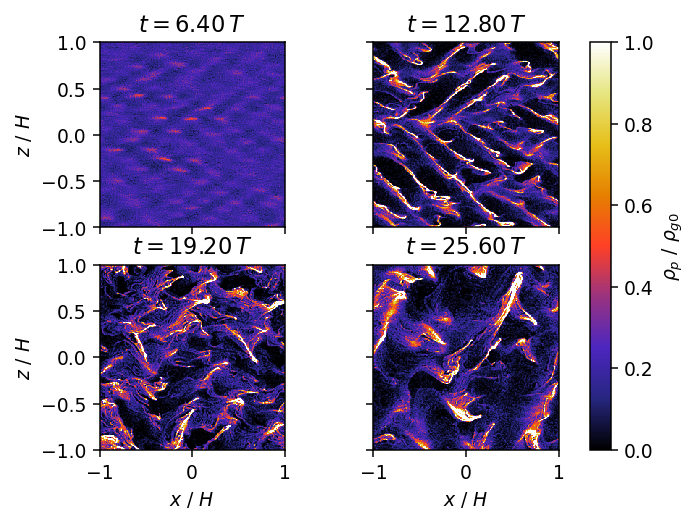

In [143]:
# Collect .athdf outputs, init sim constants and grid
athinput = athena_read.athinput('../nonlinear/BA/athinput.si')
outputs = sorted(list(Path('../nonlinear/BA/athdf').glob(athinput["job"]["problem_id"]\
                                                         +'.out2.*.athdf')))
c_s = athinput['hydro']['iso_sound_speed'] # sound speed
Omega = athinput['problem']['omega']       # local Keplerian angular frequency
H = c_s / Omega                            # gas scale height
T = 2*np.pi/Omega                          # orbital period
data = athena_read.athdf(outputs[0])
xf, zf = data['x1f']/H, data['x2f']/H

# Load data into memory
times, rhops = [], []
for output in outputs:
    data = athena_read.athdf(output)
    times.append(data['Time']/T)
    rhops.append(data['rhop'][0])          # [0]  flattens 3D array
    
# Plot
fig, axs = plt.subplots(2, 2, dpi=135)
for i,ax in enumerate(axs.flat):
    ax.set_aspect('equal')
    ax.set_title(r'$t={:.2f}\,T$'.format(times[i]))
    img = ax.pcolormesh(xf, zf, rhops[i], vmin=0, vmax=1, cmap='CMRmap')
    ax.set(xlabel=r'$x$ / $H$', ylabel=r'$z$ / $H$')
    ax.label_outer()
cb = fig.colorbar(img, ax=axs[:,:])
cb.set_label(r'$\rho_p$ / $\rho_{g0}$')

## Fig. 3

Saturated state of runs BB and BC (both at time $t=16\,T$).

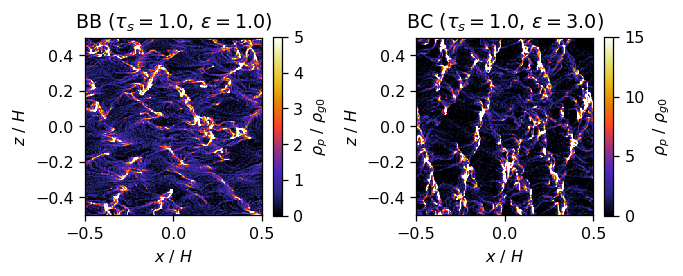

In [144]:
fig, axs = plt.subplots(1, 2, dpi=115)
runs = ['BB', 'BC']
vmaxs = [5, 15]

for i,ax in enumerate(axs.flat):
    # Load run snapshot
    athinput = athena_read.athinput('../nonlinear/%s/athinput.si'%runs[i])
    outputs = sorted(list(Path('../nonlinear/%s/athdf'%runs[i]).glob(athinput["job"]["problem_id"]\
                                                    +'.out2.*.athdf')))
    c_s = athinput['hydro']['iso_sound_speed']   # sound speed
    Omega = athinput['problem']['omega']         # local Keplerian angular frequency
    epsilon = athinput['problem']['epsilon']     # avg. BG dust/gas ρ-ratio
    tau_s = athinput['particles']['taus0']*Omega # dimensionless stopping time
    H = c_s / Omega                              # gas scale height
    T = 2*np.pi/Omega                            # orbital period
    data = athena_read.athdf(outputs[0])
    xf, zf = data['x1f']/H, data['x2f']/H
    # Plot
    ax.set_aspect('equal')
    ax.set_title(r'{:s} ($\tau_s={:.1f},\,\epsilon={:.1f}$)'.format(runs[i], tau_s, epsilon))
    img = ax.pcolormesh(xf, zf, data['rhop'][0], vmin=0, vmax=vmaxs[i], cmap='CMRmap')
    cb = fig.colorbar(img, ax=ax, shrink=0.42)
    cb.set_label(r'$\rho_p$ / $\rho_{g0}$')
    ax.set(xlabel=r'$x$ / $H$', ylabel=r'$z$ / $H$')
    ax.label_outer()
fig.tight_layout()

## Fig. 4

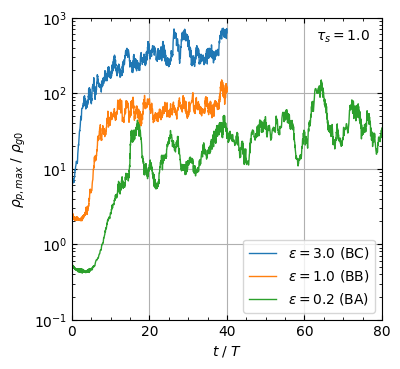

In [206]:
fig, ax = plt.subplots(figsize=(4,4), dpi=100)
runs = ['BC', 'BB', 'BA']

for run in runs:
    # Load simulation parameters and plot NAS results
    athinput = athena_read.athinput('../nonlinear/%s/athinput.si'%run)
    epsilon = athinput['problem']['epsilon']
    label = r'$\epsilon={:.1f}$ ({:s})'.format(epsilon, run)
    data = np.loadtxt('../nonlinear/%s/plots/growth.txt'%run)
    times, rhopmax = data[:, 0], data[:, 1]
    ax.semilogy(times, rhopmax, label=label, lw=1)
    
ax.set_ylabel(r'$\rho_{p,max}$ / $\rho_{g0}$')
ax.set_xlabel(r'$t$ / $T$')
ax.minorticks_on()
ax.tick_params(axis='both', which='both', top=True, right=True, direction='in')
ax.text(63, 500, r'$\tau_s={:.1f}$'.format(tau_s))
ax.set(xlim=(0, 80), ylim=(0.1, 1000))
ax.legend()
ax.grid()

## Table 2
### Flow Properties

In [220]:
runs = ['AC', 'BA', 'BB', 'BC']
t_sats = [2, 15, 10, 20]                                # See each [run].ipynb
refs = [-0.035, -0.52, -0.341, -0.118]                  # From JY07, Table 2
epsilons, tau_ss, avg_vp1s, ref_diffs = [], [], [], []

for i,run in enumerate(runs):
    athinput = athena_read.athinput('../nonlinear/%s/athinput.si'%run)
    tlim = athinput['time']['tlim']                     # time limit / T
    Np_tot = athinput['problem']['npx1']\
         *athinput['problem']['npx2']\
         *athinput['problem']['npx3']                   # total number of particles
    Omega = athinput['problem']['omega']         # local Keplerian ang. freq.
    epsilons.append(athinput['problem']['epsilon'])     # avg. BG dust/gas ρ-ratio
    Pi = athinput['problem']['duy0']                    # global rad. press. grad.
    tau_ss.append(athinput['particles']['taus0']*Omega) # dimensionless stopping time
    etav_K = Pi*c_s                                     # velocity (JY07)
    hst = athena_read.hst('../nonlinear/%s/SI.hst'%run)
    i_sat = hst['time'].size*t_sats[i]//tlim # saturation output start
    avg_vp1s.append(np.average(hst['vp1'][i_sat:])/etav_K/Np_tot)
    ref_diffs.append(100*2*np.abs((avg_vp1s[i] - refs[i]) / (avg_vp1s[i] + refs[i])))

df = pd.DataFrame(
    {
        "Run": runs,
        r"$\tau_s$": tau_ss,
        r"$\epsilon$": epsilons,
        r"$\overline{v_x}$": avg_vp1s,
        "% diff": ref_diffs
    }
)
df.style.format({
    r"$\tau_s$": "{:.1f}",
    r"$\epsilon$": "{:.1f}",
    r"$\overline{v_x}$": "{:.3f}",
    "% diff": "{:.1f}"
})

,Run,$\tau_s$,$\epsilon$,$\overline{v_x}$,% diff
0,AC,0.1,3.0,-0.030,14.4
1,BA,1.0,0.2,-0.578,10.5
2,BB,1.0,1.0,-0.339,0.5
3,BC,1.0,3.0,-0.116,2.0


## Fig. 7

## Fig. 8

## Fig. 11

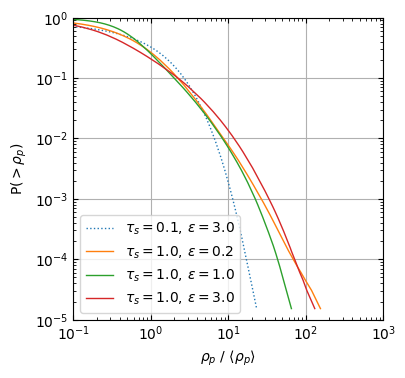

In [225]:
fig, ax = plt.subplots(figsize=(4,4), dpi=100)
runs = ['AC', 'BA', 'BB', 'BC']
lss = [':', '-', '-', '-',]

for i,run in enumerate(runs):
    athinput = athena_read.athinput('../nonlinear/%s/athinput.si'%run)
    Omega = athinput['problem']['omega']         # local Keplerian ang. freq.
    epsilon = athinput['problem']['epsilon']     # avg. BG dust/gas ρ-ratio
    tau_s = athinput['particles']['taus0']*Omega # dimensionless stopping time
    label = r'$\tau_s={:.1f},\,\epsilon={:.1f}$'.format(tau_s, epsilon)
    data = np.loadtxt('../nonlinear/%s/plots/cpdd_avg.txt'%run)
    cdf = data[:, 1]
    avg_rhops = data[:, 0]
    ax.loglog(avg_rhops, cdf, ls=lss[i], label=label, lw=1)
    
ax.minorticks_on()
ax.tick_params(axis='both', which='both', top=True, right=True, direction='in')
ax.set(xlim=(0.1, 1e3), ylim=(1e-5, 1), xlabel=r'$\rho_p$ / $\langle \rho_p \rangle$',
       ylabel=r'P$(>\rho_p)$')
ax.legend()
ax.grid()

## Fig. 15